In [1]:
#We have a problem of reproductibility here. To adress this issue we need to compute everything here without calling external function 

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'


import networkx as nx
from scipy.stats import skew
import community
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
import random


np.random.seed(55)
random.seed(55)


In [3]:
#check randomness #old don't bother with that
print(random.random())
print("0.6394267984578837")
print("0.09033985426934954")

0.09033985426934954
0.6394267984578837
0.09033985426934954


In [4]:
plt.rcParams["figure.figsize"] = (12,8)

## FUNCTIONS

In [5]:
tactic_dict={
        "Persistence":113,                     #meaning that 0-112 are in "persistence" tactic
        "Command_and_Control":39,   #113-151
        "Impact":26,                                #152-177 [sum of the previous] - [sum-1]
        "Initial_Access":19,                    #178
        "Resource_Development":45,  #197
        "Collection":37,                           #242
        "Exfiltration":18,                          #279
        "Credential_Access":63,           #297
        "Privilege_Escalation":96,         #360
        "Execution":36,                           #456
        "Defense_Evasion":184,           #492
        "Reconnaissance":43,               #676
        "Lateral_Movement":22,            #719
        "Discovery":44                           #741
    }

#another expression to help with separation of cyber risk using index of involved arrays (785)
# Calculate the total number of tactics
total_tactics = sum(tactic_dict.values())

# Create a list to store the names of the tactics
tactics_array = []

# Assign tactic names to the array based on the specified ranges
for tactic, count in tactic_dict.items():
    tactics_array.extend([tactic] * count)

# Convert the list to numpy array if necessary
tactics_array = np.array(tactics_array)

In [6]:
def setup_similitude_matrix(path_matrix='similitude_matrix.txt'):

    simi_matrix=np.loadtxt(path_matrix)

    print("check number of negative similitude : "+str(np.sum(simi_matrix < 0)))
    #we rework a bit the data so that it can be used in clustering methods
    simi_matrix[simi_matrix<0]=0

    return simi_matrix

In [7]:
def graph_creator(M):
    #create a spring graph
    m=M.copy()
    np.fill_diagonal(m, 0)
    
    # Create a graph from the similarity matrix
    G = nx.from_numpy_array(m)
    
    # Create a spring layout for the graph
    pos = nx.spring_layout(G)
    
    # Define colors for different tactics
    unique_tactics = np.unique(tactics_array)
    color_map = plt.cm.get_cmap('tab20', len(unique_tactics))  # You can choose a different colormap if you prefer
  
    
    # Assign colors to tactics
    tactic_color_dict = {tactic: color_map(i) for i, tactic in enumerate(unique_tactics)}
    
    # Assign colors to nodes based on their tactic
    node_colors = [tactic_color_dict[tactics_array[i]] for i in range(len(tactics_array))]
    
    # Draw the graph with node colors
    #nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, edge_color='grey', linewidths=1, font_size=7)

    nx.draw_networkx_nodes(G,pos, node_color=node_colors, node_size=500)

    nx.draw_networkx_edges(G,pos,edge_color='grey',alpha=0.02) 


    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=7)
    
    
    # Create legend
    legend_labels = {tactic: plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=tactic_color_dict[tactic]) for tactic in unique_tactics}
    plt.legend(legend_labels.values(), legend_labels.keys(), loc='best', title='Tactics')
    
    # Show the graph
    #plt.title("Spring Layout Graph from Similarity Matrix")
    plt.show()
    

In [8]:
def force_clustering(similarity_matrix,intensity=1):
    #force paragraph of the same tactic to have a chosen similitude with the intensity parameter
    split_down=0
    first=True
    for key in tactic_dict.keys():
        

        M=np.ones((tactic_dict[key],tactic_dict[key]))
        if first:
            forced_matrix=M

            first=False

        else:
        
            forced_matrix=np.block([ [forced_matrix,np.zeros((forced_matrix.shape[0],M.shape[1]))],
                                [np.zeros((M.shape[0],forced_matrix.shape[1])), M]])


    output=similarity_matrix.copy()

    output=output*(1-forced_matrix)+forced_matrix*intensity

    return output
 

In [9]:
def show_similitude_matrix(simi):
    # Plot the matrix with a colormap
    extent = [0, simi.shape[1],  simi.shape[0],0]
    plt.imshow(simi, cmap='summer', origin='upper', extent=extent) # 'viridis' is just one example of a colormap
    plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.04)  # Add a colorbar to show the mapping of values to colors
    
    
    
    last_split=0
    split_line=0
    for key in tactic_dict.keys():
        split_line+=tactic_dict[key]
    
        plt.text(800, split_line-(split_line-last_split)/2, key.replace("_", " "), color='black', fontsize=8, rotation=0)
    
        plt.text(split_line-(split_line-last_split)/2, -15, key.replace("_", " "), color='black', fontsize=8, rotation=45)
        
        #print(split_line)
        
        if split_line>=784:
            break
        plt.hlines(split_line-1.5,0,784,color="black",linewidths=0.5)
        plt.vlines(split_line,0,784,color="black",linewidths=0.5)
    
        last_split=split_line

        
        
    plt.show()

In [10]:
#-----------------------------------------------------------------------------------------------------------------
#           Clustering
#-----------------------------------------------------------------------------------------------------------------

#important : check that the labels is in a good format:
#array size 785
#contain class ranging from 0 to n-1

def comparator_tactic_super_tactic(labels,n_cluster=None,show_plot=True):
    if n_cluster==None:
        n_cluster=np.max(labels)+1


    tactics_name=list(tactic_dict.keys())
    overall_occurrences = np.array([np.count_nonzero(tactics_array == value) for value in tactics_name])

    entropy_shannon=0

    first=True
    
    for k in range(n_cluster):
        classe_occurences=np.array([np.count_nonzero(tactics_array[labels==k] == value) for value in tactics_name])

        proportion_in_classe=classe_occurences/overall_occurrences

        if first:
            array_proportion_in_classe=proportion_in_classe
            first=False

        else:
            array_proportion_in_classe=np.vstack((array_proportion_in_classe,proportion_in_classe))

        entropy_shannon+=-np.where(proportion_in_classe != 0, proportion_in_classe * np.log(proportion_in_classe), 0)

    #now we built the indicator of color
    
    colors_indicator=np.argmax(array_proportion_in_classe, axis=0)


    if show_plot:

        for k in range(n_cluster):    
            

            colors = ['red' if ind == k else 'skyblue' for ind in colors_indicator]
           
            plt.bar(tactics_name, array_proportion_in_classe[k], color=colors)
            plt.xlabel('Tactics')
            plt.ylabel('Proportion of tactics in class '+str(k))
            plt.ylim([0,1])
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

          
        
        
        plt.bar(np.array(tactics_name),entropy_shannon, color="green")
        plt.xlabel('Tactics')
        plt.ylabel('Estimated Shannon entropy for each tactic after the clustering ')
        
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    print("lower entropy means higher exclusivity to a 'super tactic'")
    print("sum of all exclusive entropy = ",np.sum(entropy_shannon))

    return np.sum(entropy_shannon)

In [11]:
#-----------------------------------------------------------------------------------------------------------------
#           Clustering presentation results
#-----------------------------------------------------------------------------------------------------------------

def organiser1(lab):
    to_switch_with_0 = np.argmax(np.bincount(lab[197:241]))
    

    transformed_lab = [0 if num == to_switch_with_0 else to_switch_with_0 if num == 0 else num for num in lab]
    return np.array(transformed_lab)


def organiser2(lab):
    to_switch_with_1 = np.argmax(np.bincount(lab[456:491]))
    

    transformed_lab = [1 if num == to_switch_with_1 else to_switch_with_1 if num == 1 else num for num in lab]
    return np.array(transformed_lab)



def organiser3(lab):
    n_cluster=np.max(lab)+1
    if n_cluster>2:
        to_switch_with_2 = np.argmax(np.bincount(lab[719:740]))
        
    
        transformed_lab = [2 if num == to_switch_with_2 else to_switch_with_2 if num == 2 else num for num in lab]
        return np.array(transformed_lab)
    else:
        return lab



def comparator_method_clustering(dict,fig_size=(20, 30)):
    #fontsize
    a=12
    #number_rows
    number_rows=0
    for lab in dict.values():
        number_rows=np.max(np.array([np.max(lab),number_rows]))

    number_rows+=2

    #number_columns
    number_columns=len(dict.keys())

    # Create a figure and axis objects
    fig, axs = plt.subplots( number_columns,number_rows, figsize=fig_size)



    #useful for the second graph
    method_entropy=[]
    method_balanced=[]

    
    for i,method in enumerate(dict.keys()): #over columns
        
            labels=dict[method]
            
            labels=organiser3(labels) #don't change the order please!
            labels=organiser1(labels)
            labels=organiser2(labels)
            
            #the organiser allows to have roughly corresponding name of class across the method
            

           
            n_cluster=np.max(labels)+1
        
        
            tactics_name=list(tactic_dict.keys())
            overall_occurrences = np.array([np.count_nonzero(tactics_array == value) for value in tactics_name])
        
            entropy_shannon=0
        
            first=True
            
            for k in range(n_cluster):
                classe_occurences=np.array([np.count_nonzero(tactics_array[labels==k] == value) for value in tactics_name])
        
                proportion_in_classe=classe_occurences/overall_occurrences
        
                if first:
                    array_proportion_in_classe=proportion_in_classe
                    first=False
        
                else:
                    array_proportion_in_classe=np.vstack((array_proportion_in_classe,proportion_in_classe))
        
                entropy_shannon+=-np.where(proportion_in_classe != 0, proportion_in_classe * np.log(proportion_in_classe), 0)
        
            #now we built the indicator of color
            
            colors_indicator=np.argmax(array_proportion_in_classe, axis=0)
        
        
            
        
            for k in range(n_cluster):    
                
    
                colors = ['red' if ind == k else 'skyblue' for ind in colors_indicator]


                axs[i,k].bar(np.arange(14)+1, array_proportion_in_classe[k], color=colors)
                axs[i,k].xaxis.set_major_locator(ticker.MultipleLocator(base=2))
                axs[i,k].set_ylim([0,1])
                
                if k==0:
                    #axs[i,k].set_title('0')
                    axs[i,k].set_ylabel(method+'\n\n'+'Prop. class '+str(k), fontsize=a)

                else:
                    axs[i,k].set_ylabel('Prop. class '+str(k), fontsize=a)


        
           
            if n_cluster<number_rows-1:
                axs[i,number_rows-2].bar([1,5,14], [0,1,0.5], color="white")
                axs[i,number_rows-2].set_ylim([0,1])

            #compute balanced_score
            balanced_score=np.round(np.std(np.array(list(Counter(labels).values()))),1)

            


        
            text='entropy sum. = '+str(np.round(np.sum(entropy_shannon),2))+'\n\n'+'balanced score = '+str(np.round(balanced_score,1))
            axs[i,number_rows-2].text(2, 0.5, text, fontsize=a, color='black')  

            method_entropy.append(np.sum(entropy_shannon))
            method_balanced.append(balanced_score)
            

            
            axs[i,number_rows-1].bar(np.arange(14)+1,entropy_shannon, color="green")
            axs[i,number_rows-1].set_ylabel('Entropy', fontsize=a)
            axs[i,number_rows-1].xaxis.set_major_locator(ticker.MultipleLocator(base=2))
            axs[i,number_rows-1].set_ylim([0,1.5])
    

            for k in range(n_cluster,number_rows-1):   
                axs[i,k].set_xticks([])
                axs[i,k].set_yticks([])
                
            
               


    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 6))
    plt.scatter(method_balanced,method_entropy)
    for i,method in enumerate(dict.keys()):
        if method == "kmean. n=3":
            plt.text(method_balanced[i],method_entropy[i]+0.3,"                             "+method,fontsize=8,ha="center")
        elif method == "spectral.\n n=4 egn=8":
            plt.text(method_balanced[i]+5,method_entropy[i]+0.3,""+method,fontsize=8,ha="center")
   
        else:
            plt.text(method_balanced[i],method_entropy[i]+0.3,method,fontsize=8,ha="center")

    plt.xlabel("Score of balance between classes")
    plt.ylabel("Entropy (heterogeneity between classes)")
    plt.xlim([40,130])
    plt.ylim([3,15])
    plt.show()

In [12]:
def graph_creator_with_labels(M,lab):
    #create a spring graph
    m=M.copy()
    np.fill_diagonal(m, 0)
    
    # Create a graph from the similarity matrix
    G = nx.from_numpy_array(m)
    
    # Create a spring layout for the graph
    pos = nx.spring_layout(G)
    
    # Define colors for different tactics
    unique_tactics = np.unique(tactics_array)
    color_map = plt.cm.get_cmap('tab20', len(unique_tactics))  # You can choose a different colormap if you prefer
  
    
    # Assign colors to tactics
    tactic_color_dict = {tactic: color_map(i) for i, tactic in enumerate(unique_tactics)}
    
    # Assign colors to nodes based on their tactic
    node_colors = [tactic_color_dict[tactics_array[i]] for i in range(len(tactics_array))]
    
    # Draw the graph with node colors
    #nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, edge_color='grey', linewidths=1, font_size=7)

    # Define colors for different classes
    class_colors = {0: 'm', 1: 'k', 2: 'b', 3: 'y', 4: 'c', 5: 'r'}  # Add colors for labels 4, 5, and 6

    # Generate node colors based on class labels
    outline_colors = [class_colors[label] for label in lab]

    #nx.draw_networkx_nodes(G,pos, node_color=node_colors, node_size=500)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, edgecolors=outline_colors, linewidths=2)

    nx.draw_networkx_edges(G,pos,edge_color='grey',alpha=0.02) 


    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=7)
    
    
    # Create legend
    legend_labels = {tactic: plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=tactic_color_dict[tactic]) for tactic in unique_tactics}
    plt.legend(legend_labels.values(), legend_labels.keys(), loc='best', title='Tactics')
    
    # Show the graph
    #plt.title("Spring Layout Graph from Similarity Matrix")
    plt.show()

In [13]:
def clustering_kmean(simi_matrix, n_clusters):
    
    # Initialize KMeans with precomputed distance
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
    
    # Fit the model with precomputed distance
    kmeans.fit_predict(simi_matrix)
    
    # Get cluster assignments
    labels = kmeans.labels_

    return labels



def louvain_method(sim_mat):
    #check Fast unfolding of communities in large networks, Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte,
    #Renaud Lefebvre, Journal of Statistical Mechanics: Theory and Experiment 2008(10), P10008 (12pp)


    
    #Important: louvain method find on its own the optimal number of cluster ("communities")
    # Convert the matrix into a NetworkX graph
    G = nx.Graph(sim_mat.copy())

    # Apply the Louvain method
    partition = community.best_partition(G,random_state=42)


    labels=np.array(list(partition.values()))

    return labels
        

def spectral_clustering(sim_mat,n_clusters, n_eigenvectors=None):
    #https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

    if n_eigenvectors==None:
        n_eigenvectors=n_cluster
    
    sc = SpectralClustering(n_clusters=n_clusters, n_components=n_eigenvectors, affinity='precomputed', random_state=42)
    labels = sc.fit_predict(sim_mat)

    return labels


# APPLICATIONS

In [14]:
#------------------------------------------------------------------------------------------------------------------------------------
#                       construct matrix of similarities with and without constraints
#------------------------------------------------------------------------------------------------------------------------------------
#simple similarity matrix, nothing fancy...
sim_mat=setup_similitude_matrix()

check number of negative similitude : 0


In [15]:
#sim mat where we force a similarity of intensity 1 among same tactic paragraph
forced=force_clustering(sim_mat.copy(),1)

#sim mat but too low similitude are reduced to 0
sim_mat_modif=sim_mat.copy()
threshold=0.3
sim_mat_modif[sim_mat_modif<threshold]=0

#sim_mat_modif where we force a similarity of intensity 1 among same tactic paragraph
forced_modif=force_clustering(sim_mat_modif.copy(),1)

#sim mat but too low or too high similitude are reduced to 0 and 0.5 respectively
sim_mat_modif2=sim_mat.copy()
threshold1=0.2
threshold2=0.85
sim_mat_modif2[sim_mat_modif2<threshold1]=0
sim_mat_modif2[sim_mat_modif2>threshold2]=0.5

# Presentation of the similitude matrix

C:\Users\natha\AppData\Local\Temp\ipykernel_9232\924873200.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_tactics))  # You can choose a different colormap if you prefer


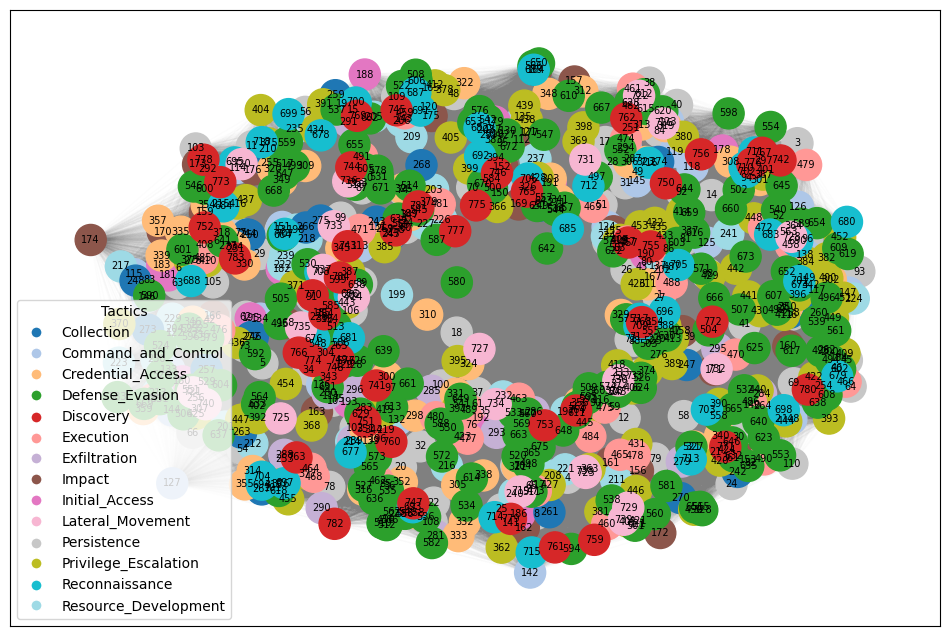

In [16]:
graph_creator(sim_mat) 

C:\Users\natha\AppData\Local\Temp\ipykernel_9232\924873200.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_tactics))  # You can choose a different colormap if you prefer


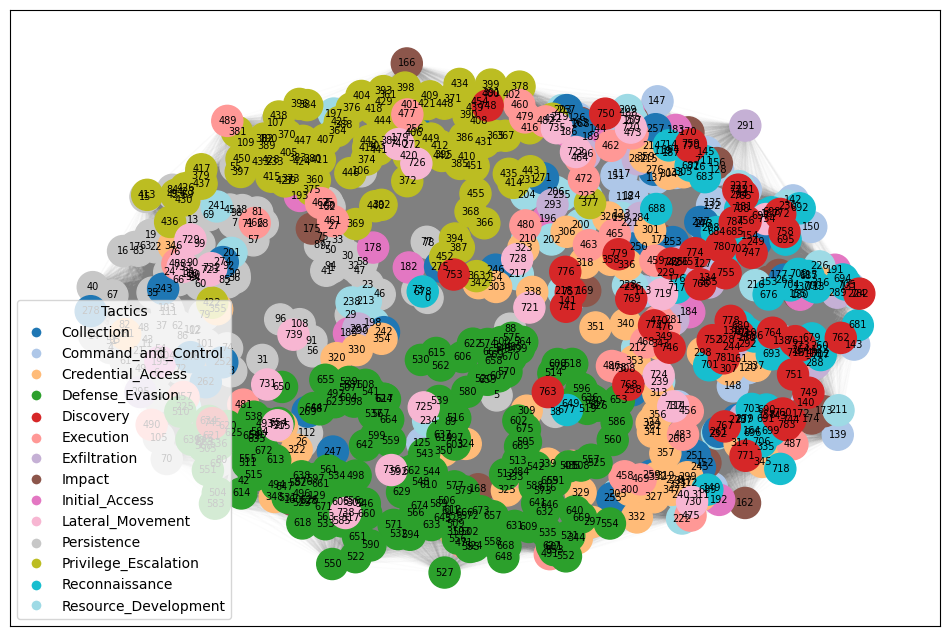

In [17]:
graph_creator(forced) 

C:\Users\natha\AppData\Local\Temp\ipykernel_9232\924873200.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_tactics))  # You can choose a different colormap if you prefer


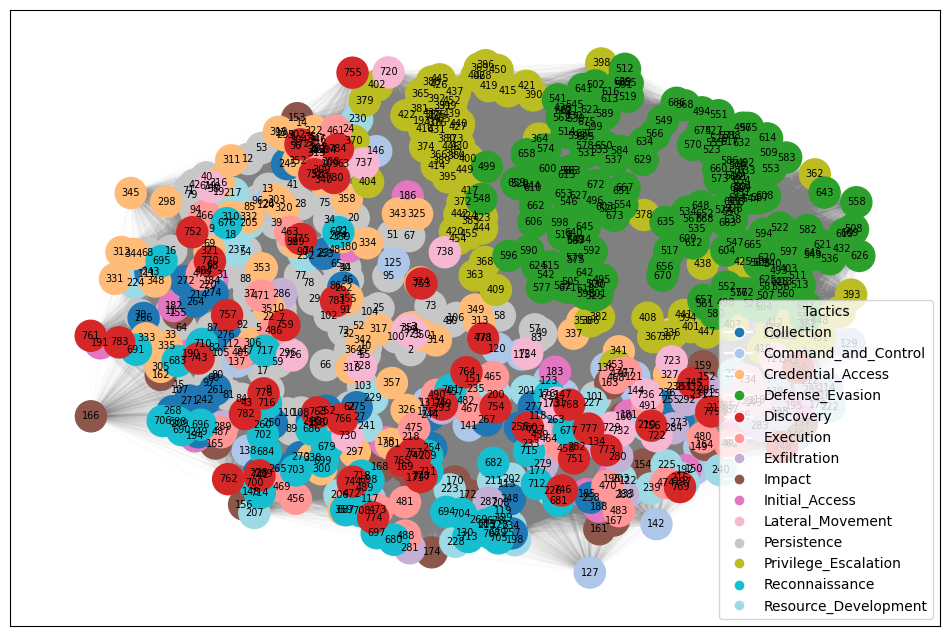

In [18]:
graph_creator(forced_modif) 

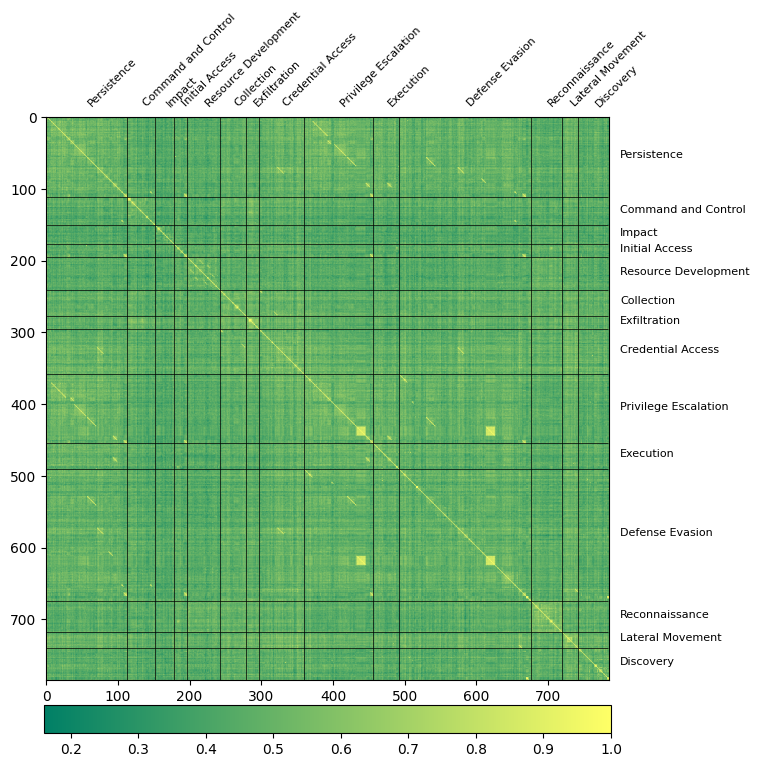

In [19]:
show_similitude_matrix(sim_mat)

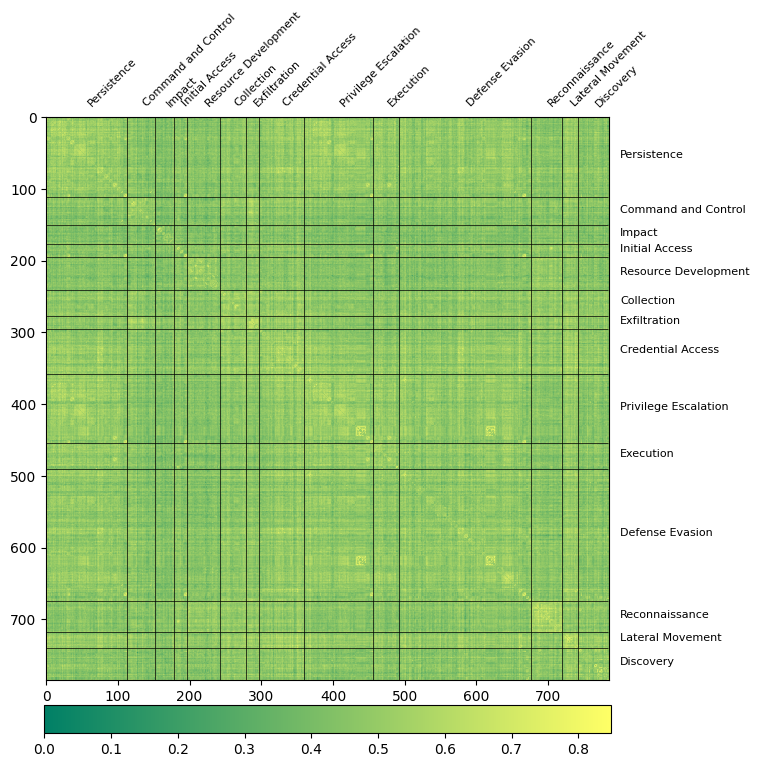

In [20]:
show_similitude_matrix(sim_mat_modif2)

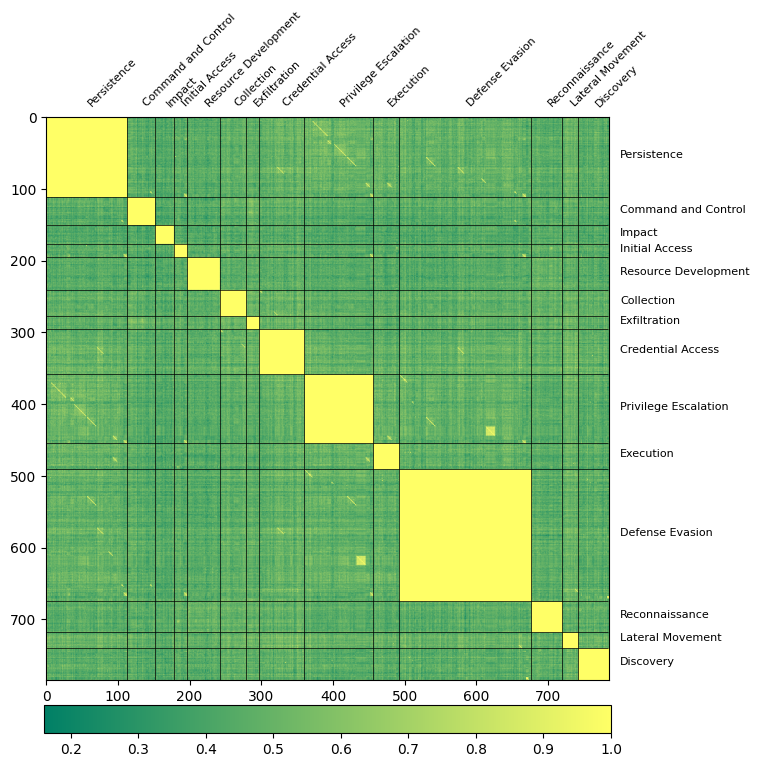

In [21]:
show_similitude_matrix(forced)

# Clustering methods

In [22]:
#------------------------------------------------------------------------------------------------------------------------------------
#                       construct matrix of similarities with and without constraints
#------------------------------------------------------------------------------------------------------------------------------------
#simple similarity matrix, nothing fancy...
sim_mat=setup_similitude_matrix()

#sim mat where we force a similarity of intensity 1 among same tactic paragraph
forced=force_clustering(sim_mat.copy(),1)

#sim mat but too low similitude are reduced to 0
sim_mat_modif=sim_mat.copy()
threshold=0.3
sim_mat_modif[sim_mat_modif<threshold]=0

#sim_mat_modif where we force a similarity of intensity 1 among same tactic paragraph
forced_modif=force_clustering(sim_mat_modif.copy(),1)

#sim mat but too low or too high similitude are reduced to 0 and 0.5 respectively
sim_mat_modif2=sim_mat.copy()
threshold1=0.2
threshold2=0.85
sim_mat_modif2[sim_mat_modif2<threshold1]=0
sim_mat_modif2[sim_mat_modif2>threshold2]=0.5

check number of negative similitude : 0


In [23]:
#------------------------------------------------------------------------------------------------------------------------------------
#                       apply clustering methods and store results
#------------------------------------------------------------------------------------------------------------------------------------


dict_output_clustering={}

labels=clustering_kmean(sim_mat,4)
dict_output_clustering["kmean. n=4"]=labels

labels=clustering_kmean(sim_mat,3)
dict_output_clustering["kmean. n=3"]=labels

labels=clustering_kmean(sim_mat_modif2,3)
dict_output_clustering["kmean. n=3\n hg.+lw. tresh."]=labels

labels=louvain_method(sim_mat) #note: louvain determine automatically the optimal number of clusters
dict_output_clustering["louvain"]=labels

labels=louvain_method(sim_mat_modif) 
dict_output_clustering["louvain\n lw. tresh."]=labels

labels_top=louvain_method(sim_mat_modif2) 
dict_output_clustering["louvain\n hg.+lw. tresh."]=labels_top

labels=spectral_clustering(sim_mat,2,6)
dict_output_clustering["spectral.\n n=2 egn=6"]=labels

labels=spectral_clustering(sim_mat,3,6)
dict_output_clustering["spectral.\n n=3 egn=6"]=labels

labels=spectral_clustering(sim_mat,4,6)
dict_output_clustering["spectral.\n n=4 egn=6"]=labels

labels=spectral_clustering(sim_mat,4,8)
dict_output_clustering["spectral.\n n=4 egn=8"]=labels

labels=spectral_clustering(sim_mat_modif2,4,8)
dict_output_clustering["spectral.\n n=4 egn=8\n hg.+lw. tresh."]=labels

labels=spectral_clustering(sim_mat,4,10)
dict_output_clustering["spectral.\n n=4 egn=10"]=labels

labels=spectral_clustering(sim_mat,5,10)
dict_output_clustering["spectral.\n n=5 egn=10"]=labels

#labels=clustering_kmean(forced,3)
#dict_output_clustering["kmean.\n n=3 forced"]=labels

C:\Users\natha\AppData\Local\Temp\ipykernel_9232\49414638.py:92: RuntimeWarning: divide by zero encountered in log
  entropy_shannon+=-np.where(proportion_in_classe != 0, proportion_in_classe * np.log(proportion_in_classe), 0)
C:\Users\natha\AppData\Local\Temp\ipykernel_9232\49414638.py:92: RuntimeWarning: invalid value encountered in multiply
  entropy_shannon+=-np.where(proportion_in_classe != 0, proportion_in_classe * np.log(proportion_in_classe), 0)


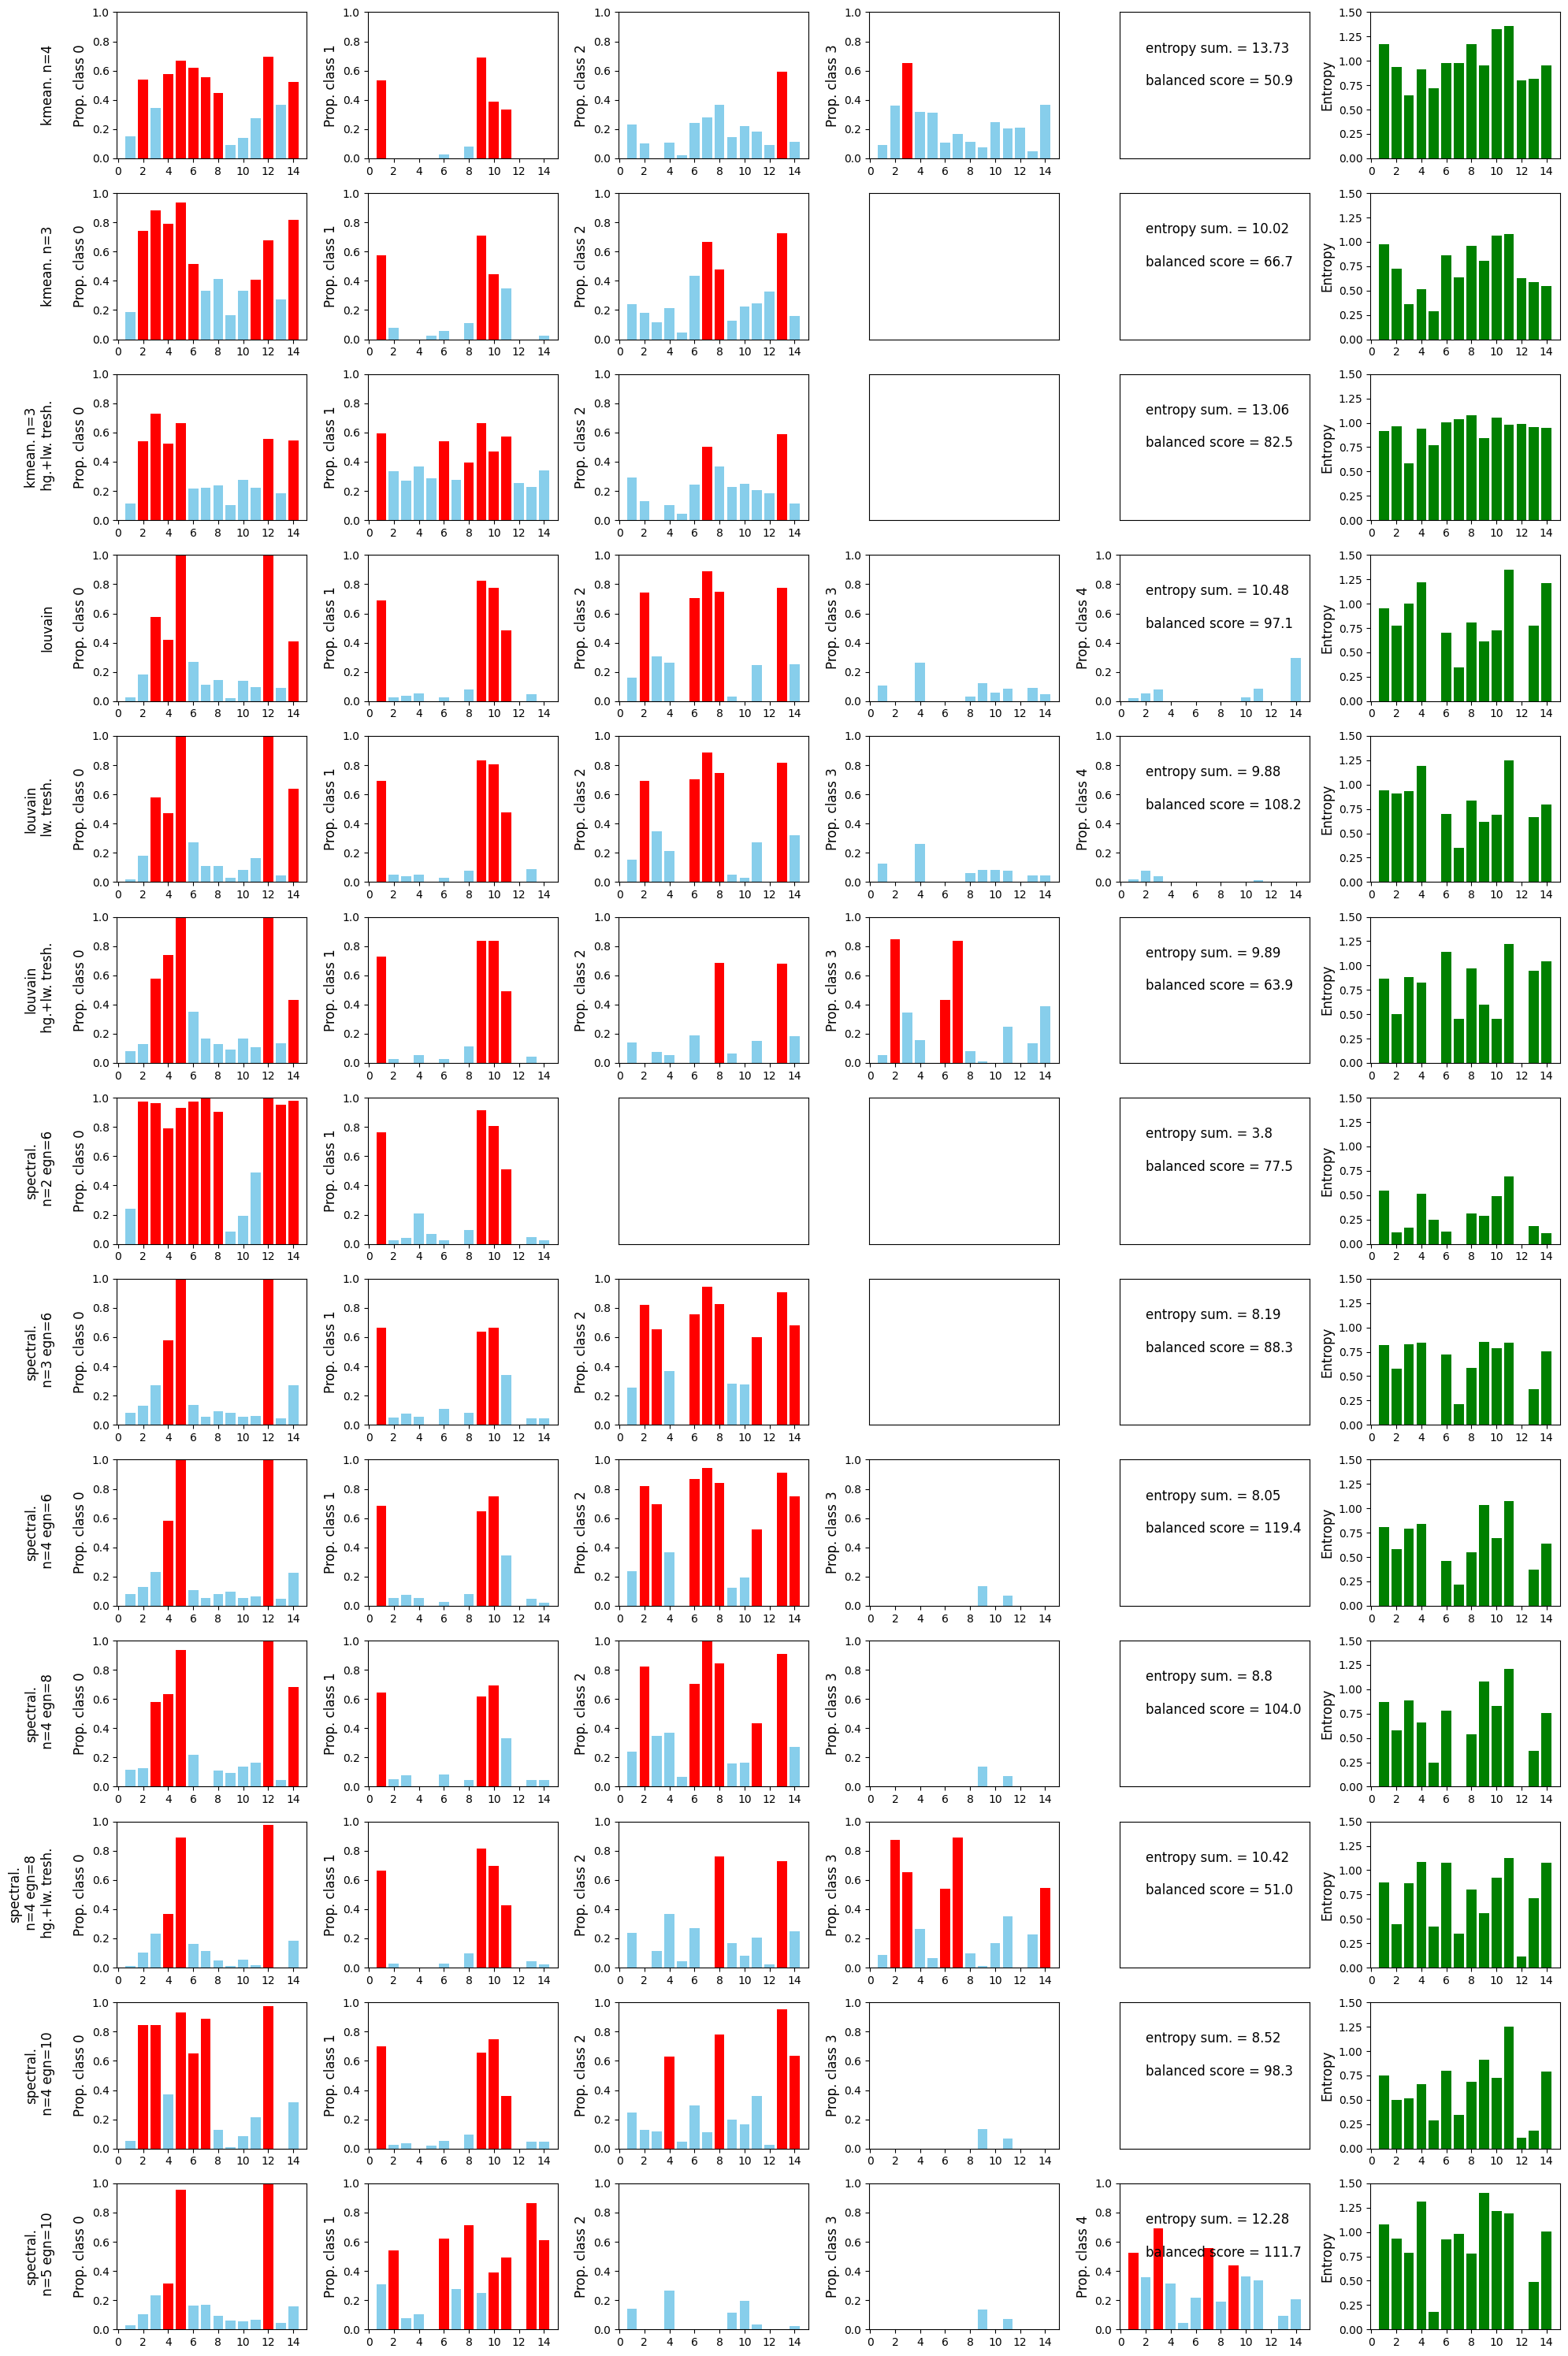

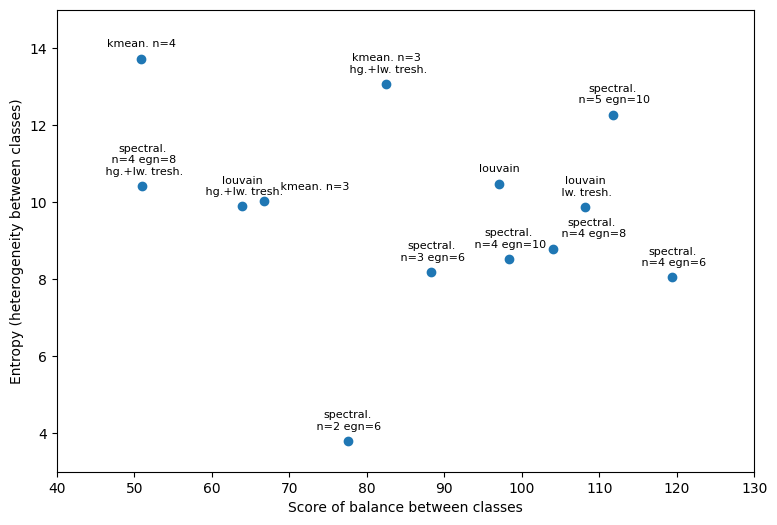

In [24]:
comparator_method_clustering(dict_output_clustering)

In [25]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
dict_output_clustering={}



labels=clustering_kmean(sim_mat_modif2,3)
dict_output_clustering["kmean. n=3\n hg.+lw. tresh."]=labels

labels=clustering_kmean(sim_mat_modif2,4)
dict_output_clustering["kmean. n=4\n hg.+lw. tresh."]=labels


labels_top=louvain_method(sim_mat_modif2) 
dict_output_clustering["louvain\n hg.+lw. tresh."]=labels_top

labels=spectral_clustering(sim_mat_modif2,4,6)
dict_output_clustering["spectral.\n n=4 egn=6\n hg.+lw. tresh."]=labels

labels=spectral_clustering(sim_mat_modif2,4,8)
dict_output_clustering["spectral.\n n=4 egn=8\n hg.+lw. tresh."]=labels

labels=spectral_clustering(sim_mat_modif2,4,10)
dict_output_clustering["spectral.\n n=4 egn=10\n hg.+lw. tresh."]=labels



In [ ]:
comparator_method_clustering(dict_output_clustering,fig_size=(20,15))

# STOP

In [ ]:
STOP

In [ ]:
#------------------------------------------------------------------------------------------------------------------------------------
#                       construct matrix of similarities with and without constraints
#------------------------------------------------------------------------------------------------------------------------------------
#simple similarity matrix, nothing fancy...
sim_mat=setup_similitude_matrix()

dict_sim_mat={}
for th_bottom in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45]:
    for th_top in [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]:
        for corrected_value in [0.5,0.6,0.7]:
        
    
            #sim mat but too low or too high similitude are reduced to 0 and 0.5 respectively
            sim_mat_modif_tuning=sim_mat.copy()
            
            sim_mat_modif_tuning[sim_mat_modif2<th_bottom]=0
            sim_mat_modif_tuning[sim_mat_modif2>th_top]=corrected_value

            name=str(th_bottom).replace(".", "")+"|"+str(th_top).replace(".", "")+"|"+str(corrected_value).replace(".", "")

            dict_sim_mat[name]=sim_mat_modif_tuning

#------------------------------------------------------------------------------------------------------------------------------------
#                       apply clustering methods and store results
#------------------------------------------------------------------------------------------------------------------------------------
dict_output_clustering_tuning={}
for name in dict_sim_mat.keys():
    
    

    labels=louvain_method(dict_sim_mat[name]) 
    dict_output_clustering[name]=labels



In [ ]:
comparator_method_clustering(dict_output_clustering_tuning)

In [ ]:
graph_creator_with_labels(sim_mat_modif2,labels_top) 